# Initializations

In [1]:
import numpy as np
import pandas as pd

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

import warnings
warnings.filterwarnings('ignore')

import gzip
import cPickle as pickle

In [2]:
from IPython import parallel

rc = parallel.Client()
all_engines = rc[:]
lbv = rc.load_balanced_view()

print len(all_engines)

48


In [3]:
%%px --local

import sys
sys.path.append("/home/nbserver/urbanization-patterns/cityanalysis")
from cityanalysis import City
from cityanalysis import fractal_dimension


In [4]:
%%px --local 

from skimage.transform import resize
from skimage.io import imread, imsave

def read_img(f, imgSize=None, scale=False):
    img = imread(f)
    if imgSize is not None:
        img = resize(img, (imgSize, imgSize), preserve_range=True)
    if scale:
        img = (img - img.min()) / float((img.max() - img.min()))
    return img

In [5]:
import matplotlib.cm as cm

def overlay_mask(img, mask, ax, alpha=0.2):
    masked_data = np.ma.masked_where(mask, img)
    # Overlay the two images
    ax.imshow(img, cmap=cm.RdYlGn)
    ax.imshow(masked_data, cmap=cm.gray, interpolation='none', alpha=alpha)


# Show stats on one example

First example: Paris, a radial, landlocked city with some lakes around.

In [172]:
myfile_SAR = '/home/data/world-cities/spatial-maps/raw/SAR_united-states_san-francisco_medium_930470_37.7554_-122.4433.tif'
myfile_POP = '/home/data/world-cities/spatial-maps/raw/POP_united-states_san-francisco_medium_930470_37.7554_-122.4433.tif'
myfile_NLI = '/home/data/world-cities/spatial-maps/raw/NLI_united-states_san-francisco_medium_930470_37.7554_-122.4433.tif'
myfile_BND = '/home/data/world-cities/spatial-maps/raw/BND_united-states_san-francisco_medium_930470_37.7554_-122.4433.tif'
myfile_WTR = '/home/data/world-cities/spatial-maps/raw/WTR_united-states_san-francisco_medium_930470_37.7554_-122.4433.tif'
cityname = "San Francisco"

In [179]:
myfile_SAR = '/home/data/world-cities/spatial-maps/raw/SAR_france_paris_large_2483685_48.8566_2.3423.tif'
myfile_POP = '/home/data/world-cities/spatial-maps/raw/POP_france_paris_large_2483685_48.8566_2.3423.tif'
myfile_NLI = '/home/data/world-cities/spatial-maps/raw/NLI_france_paris_large_2483685_48.8566_2.3423.tif'
myfile_BND = '/home/data/world-cities/spatial-maps/raw/BND_france_paris_large_2483685_48.8566_2.3423.tif'
myfile_WTR = '/home/data/world-cities/spatial-maps/raw/WTR_france_paris_large_2483685_48.8566_2.3423.tif'
cityname = "Paris"

In [180]:
img = []
for f in [myfile_SAR, myfile_POP, myfile_NLI]:
    img.append(read_img(f))
img = np.concatenate([a[...,np.newaxis] for a in img], axis=2)
   
bounds = read_img(myfile_BND)
mask = read_img(myfile_WTR,scale=True)

mycity = City(img, name=cityname, mask=mask, bounds=bounds, 
              sources=["built", "pop", "lum"])

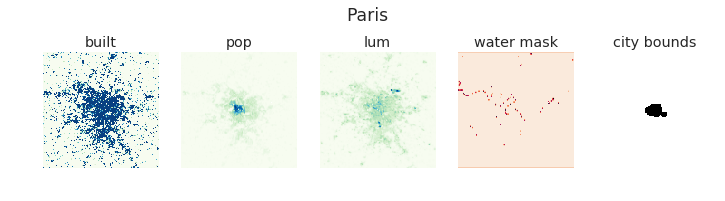

In [181]:
sns.set_context("notebook", font_scale=1.2)

fig, ax = plt.subplots(1,len(mycity.sources)+2,figsize=(12,3))
for i,s in enumerate(mycity.sources):
    ax[i].imshow(mycity.M[...,i], cmap=cm.GnBu); 
    ax[i].axis("off"); ax[i].set_title(s)

ax[len(mycity.sources)].imshow(mycity.mask); 
ax[len(mycity.sources)].axis("off"); 
ax[len(mycity.sources)].set_title("water mask")
# overlay_mask(mycity.mask, mycity.bounds, ax[1])

ax[len(mycity.sources)+1].imshow(mycity.bounds, cmap=cm.Greys); 
ax[len(mycity.sources)+1].axis("off"); 
ax[len(mycity.sources)+1].set_title("city bounds")

fig.suptitle(mycity.name)

#### Fraction of occupied area

In [10]:
mycity.compute_average(within_bounds=True)
mycity.avg_areas

{'built': 0.85308697370421038,
 'lum': 69.574852713178288,
 'pop': 10047.314604651163}

In [11]:
mycity.sum_areas

{'built': 220.09643921568627,
 'lum': 17950.311999999998,
 'pop': 2592207.1680000001}

#### Distribution of patch areas

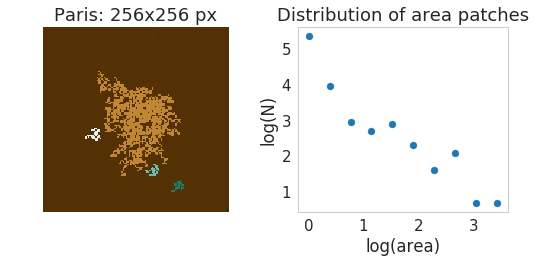

In [12]:
sns.set_context("notebook", font_scale=1.5)

mycity.compute_regions()
areas = mycity.regions['built']
areas_distr, bins = mycity.areas_distr['built'][0], mycity.areas_distr['built'][1]

# plot just top 5 areas
mask1 = mycity.masks_regions['built'].copy()
for a in areas[5:]:
    mask1[mask1==a[0]] = 0

fig, ax = plt.subplots(1,2, figsize=(8,4))
imgplot = ax[0].imshow(mask1)
imgplot.set_cmap('BrBG')
ax[0].set_title("%s: 256x256 px" % mycity.name)
ax[0].axis("off")

# plot distribution of area sizes
ax[1].scatter(np.log(bins), areas_distr, marker="o")
ax[1].set_title("Distribution of area patches")
ax[1].set_ylabel("log(N)")
ax[1].set_xlabel("log(area)")

plt.tight_layout()

#### Fractal dimension

('Minkowski-Bouligand dimension (computed): ', nan)
('Haussdorf dimension (theoretical):        ', 1.5849625007211563)


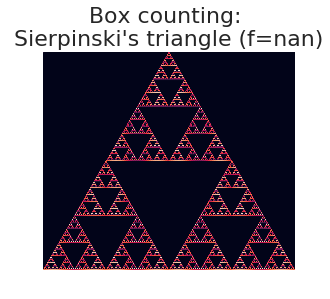

In [13]:
I = read_img("sierpinski.png")
plt.imshow(1-I)
plt.axis("off")
plt.title("Box counting: \nSierpinski's triangle (f=%2.2f)"%fractal_dimension(I)[0], 
          fontsize=22)

print("Minkowski-Bouligand dimension (computed): ", fractal_dimension(I)[0])
print("Haussdorf dimension (theoretical):        ", (np.log(3)/np.log(2)))

In [14]:
frac_dim = mycity.compute_fractal_dim(0, within_bounds=False)
print mycity.fractal_dim

_, log_box_sizes, log_box_counts = fractal_dimension(mycity.M[:,:,0])

{'built': 1.9575805118782876}


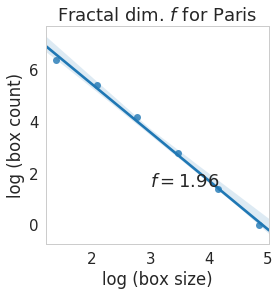

In [15]:
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(4,4))
ax = sns.regplot(log_box_sizes, log_box_counts, lowess=False)
plt.xlabel("log (box size)")
plt.ylabel("log (box count)")
plt.title("Fractal dim. $f$ for %s" % mycity.name)

ax.annotate('$f=$%.2f'%frac_dim['built'], xy=(2, 1), xytext=(3, 1.5))


#### Compute distance profiles

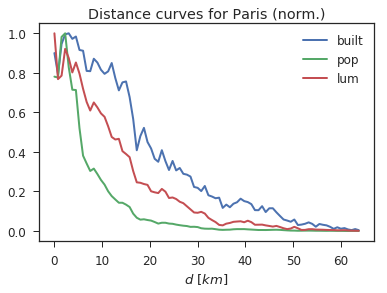

In [182]:
profiles = mycity.compute_profile(method="raysampling", step=1)

L = len(profiles.values()[0][0])
xlabels = np.arange(L) * 0.75

plt.figure(figsize=(6,4))
for c,p in profiles.iteritems():
    plt.plot(xlabels, p[0]/np.nanmax(p[0]), label=c, lw=2)
plt.legend(loc="best")
plt.title("Distance curves for %s (norm.)"%mycity.name)
plt.xlabel("$d \ [km]$")

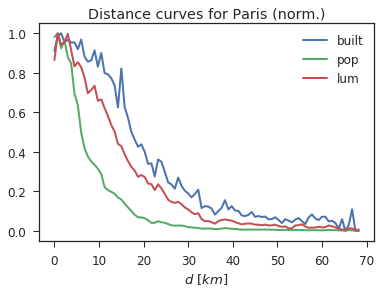

In [183]:
# using radial estimation method

profiles = mycity.compute_profile(method="radial", step=1)

L = len(profiles.values()[0][0])
xlabels = np.arange(L) * 0.75

plt.figure(figsize=(6,4))
for c,p in profiles.iteritems():
    plt.plot(xlabels, p[0]/np.nanmax(p[0]), label=c, lw=2)
plt.legend(loc="best")
plt.title("Distance curves for %s (norm.)"%mycity.name)
plt.xlabel("$d \ [km]$")

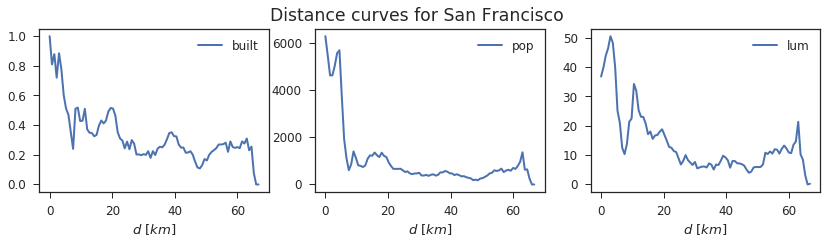

In [177]:
# using radial estimation method 

profiles = mycity.compute_profile(method="radial", step=1)

L = len(profiles.values()[0][0])
xlabels = np.arange(L) * 0.75

fig, ax = plt.subplots(1,3,figsize=(14,3))
for (c,p),a in zip(profiles.iteritems(),ax):
    a.plot(xlabels, p[0], label=c, lw=2)
    a.set_xlabel("$d \ [km]$")
    a.legend(loc="best")
fig.suptitle("Distance curves for %s"%mycity.name)

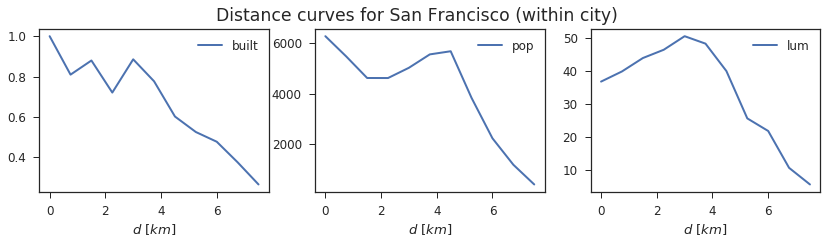

In [178]:
# using radial estimation method 

profiles = mycity.compute_profile(method="radial", step=1, within_bounds=True)

L = len(profiles.values()[0][0])
xlabels = np.arange(L) * 0.75

fig, ax = plt.subplots(1,3,figsize=(14,3))
for (c,p),a in zip(profiles.iteritems(),ax):
    a.plot(xlabels, p[0], label=c, lw=2)
    a.set_xlabel("$d \ [km]$")
    a.legend(loc="best")
fig.suptitle("Distance curves for %s (within city)"%mycity.name)

In [ ]:
plt.plot(mycity.profiles['pop'][0] / mycity.profiles['built'][0])

In [ ]:
plt.plot(mycity.profiles['lum'][0] / mycity.profiles['built'][0])

In [ ]:
plt.plot(mycity.profiles['built'][0] / mycity.profiles['pop'][0] )

In [ ]:
plt.plot(mycity.profiles['lum'][0] / mycity.profiles['pop'][0] )

# Compute spatial stats across all cities

#### Gather all data sources

In [23]:
import csv, sys

csv.field_size_limit(sys.maxsize)

# note keep_default_na=False: there are cities/provinces that are actually 
# called 'nan', and pandas interprets them as NaN values
cities_df = pd.read_csv("/home/data/world-cities/cities_over_10kpop.csv", 
                        engine='python', keep_default_na=False, 
                        usecols=["city", "province", "country", "countrycode", "area", "scale", "location", "region", "subregion", "population", "size"])

In [26]:
import geojson
from shapely.geometry import shape
from shapely.wkt import loads

parse_location = lambda s: shape(loads(s))
point2loc = lambda p: tuple(np.array(p.centroid.coords.xy).squeeze())

In [58]:
city_info = []
for i,(idx,r) in enumerate(cities_df.iterrows()):
    if i % 100 ==0:
        clear_output(wait=True)
        print "city %d/%d" % (i, len(cities_df))

    lonlat = parse_location(r['location'])
    imgLat, imgLon = point2loc(lonlat)[::-1]
    city, country = r['city'].replace(" ","-"), r['country'].strip().replace(" ","-")
    popNum, popClass = int(r['population']), r['size'].replace(" ","-")
                       
    # save city info to file
    sample_name = "%s_%s_%s_%d_%2.4f_%2.4f"%(country, city, popClass, popNum, imgLat, imgLon)
    info = r[['city', 'country', 'region', 'subregion', 'population', 'size', 'area', 'scale']].to_dict()
    city_info += [(sample_name, info)]

city 32900/32988


#### Compute stats in parallel

In [141]:
%%px --local

import numpy as np
import os
import cPickle as pickle
import gzip
from skimage.io import imsave

input_path = "/home/data/world-cities/spatial-maps/raw" 
samples_path = "/home/data/world-cities/spatial-maps/samples"

if not os.path.exists(samples_path):
    os.makedirs(samples_path)

def compute_stats_and_save(sample_info, save_dir=None):
    sample_name, basic_info = sample_info
    # check that all filenames exist
    src_vec = ['SAR', 'POP', 'NLI']
    file_names = ["%s/%s_%s.tif"%(input_path,src,sample_name) 
                  for src in src_vec]
    file_names = [f for f in file_names if os.path.exists(f)]
    if len(file_names)<len(src_vec):
        return None
    
    # load in image data
    img = []
    for f in file_names:
        img.append(read_img(f))
    img = np.concatenate([a[...,np.newaxis] for a in img], axis=2)
    mask = read_img("%s/WTR_%s.tif"%(input_path,sample_name), scale=True)
    bnds = read_img("%s/BND_%s.tif"%(input_path,sample_name))
    
    # compute stats
    city = City(img, mask=mask, bounds=bnds, name=sample_name, 
                sources=["bldg", "pop", "lum"])
    try:
        city.analyze()
    except:
        return None
    stats = {"profiles":{k:(np.nan_to_num(v[0]), np.nan_to_num(v[1]))\
                         for k,v in city.profiles.iteritems()}, 
             "frac dim":city.fractal_dim, 
             "avg area":city.avg_areas, 
             "sum area":city.sum_areas, 
             "area dis":city.areas_distr}
    all_info = dict(basic_info.items() + stats.items())
    
    # save data if requested
    if save_dir is not None:
        # save sample info
        info_file = "%s/%s.pickle.gz" % (save_dir, sample_name)
        with gzip.open(info_file, "w") as f:
            pickle.dump(all_info, f)
        # save sample data
        img_out = np.concatenate([city.M, city.mask[...,np.newaxis], city.bounds[...,np.newaxis]], axis=2)
        img_out = np.nan_to_num(img_out)
        data_file = "%s/%s.tif" % (save_dir, sample_name)
        imsave(data_file, img_out)
    
    # return info
    return all_info

In [129]:
city_info[1]

('vietnam_-huoai_very-small_36132_11.4301_107.6351',
 {'area': 496.499818128,
  'city': ' huoai',
  'country': 'vietnam',
  'population': 36132.0,
  'region': 'Asia',
  'scale': 35.334830501,
  'size': 'very-small',
  'subregion': 'South-Eastern Asia'})

In [143]:
# test saving and reloading data

info = compute_stats_and_save(city_info[0], save_dir=samples_path)

from skimage.io import imread

tmp = imread(samples_path + "/" + city_info[0][0] + ".tif")
tmp.shape

(128, 128, 5)

In [128]:
%%timeit
info = compute_stats_and_save(city_info[1])

1 loop, best of 3: 1.4 s per loop


In [148]:
res = lbv.map_async(lambda src: compute_stats_and_save(src, save_dir=samples_path), 
                    city_info)


In [161]:
res.progress

32988

#### Also save city statistics as a single file 

In [162]:
idx_ok = [r is not None for _,r in enumerate(res.result()) ]
tot = dict(zip([i[0] for i,ok in zip(city_info, idx_ok) if ok], 
         [dict(i[1].items() + d.items()) for i,d,ok in zip(city_info,res.result(), idx_ok) if ok]))

len(idx_ok), sum(idx_ok)

(32988, 30877)

In [164]:
with gzip.open("/home/data/world-cities/spatial-maps/stats_cities_over10kpop.pickle.gz", "w") as f:
    pickle.dump(tot, f)

# Analyze spatial statistics over all cities 

In [ ]:
# with gzip.open(dataroot + "stats_25k_cities.pickle.gz", "r") as f:
#     tot = pickle.load(f)

Average built area $a$

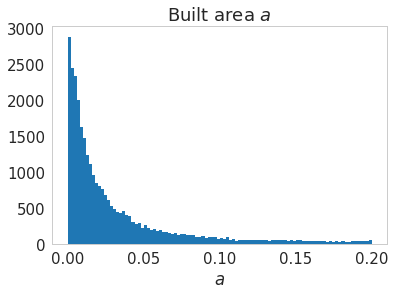

In [166]:
a_sar = np.array([v['avg area']['bldg'] for k,v in tot.iteritems()])

sns.set_context("notebook", font_scale=1.5)
plt.figure(figsize=(6,4))
_ = plt.hist(a_sar, bins=100, range=(0,0.2))
plt.title("Built area $a$")
plt.xlabel("$a$")

Fractal dimension $f$

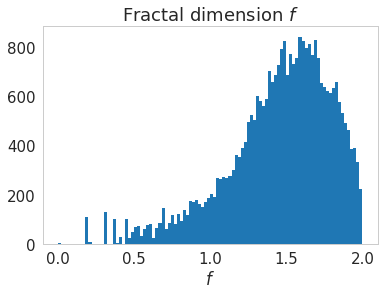

In [167]:
f_sar = np.array([v['frac dim']['bldg'] for k,v in tot.iteritems()])

sns.set_context("notebook", font_scale=1.5)
plt.figure(figsize=(6,4))
_ = plt.hist(f_sar, bins=100)
plt.title("Fractal dimension $f$")
plt.xlabel("$f$")

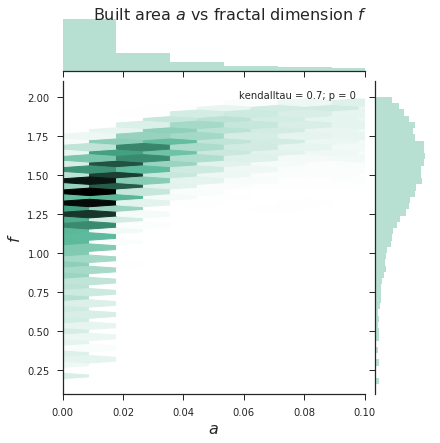

In [171]:

from scipy.stats import kendalltau
sns.set_context("notebook", font_scale=1.5)
sns.set(style="ticks")

plt.figure(figsize=(6,4))
g = sns.jointplot(a_sar, f_sar, xlim=(0,0.1), ylim=(0.1,2.1),
              kind="hex", stat_func=kendalltau, color="#4CB391")
g.fig.suptitle("Built area $a$ vs fractal dimension $f$", fontsize=16)
g.ax_joint.set_xlabel("$a$", fontsize=16)
g.ax_joint.set_ylabel("$f$", fontsize=16)

In [ ]:
a_sar.shape